<a href="https://colab.research.google.com/github/sebinbusra/dr.chatbot/blob/main/multi_agent_langgraph_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Multi-agent Collaboration

Tek bir ajan genellikle tek bir alanda birkaç araç kullanarak etkili bir şekilde çalışabilir, ancak güçlü modeller, örneğin `gpt-4` gibi, birçok aracı kullanmada o kadar etkili olmayabilir. Karmaşık görevleri ele almanın bir yolu, "böl ve fethet" yaklaşımıdır: her görev veya alan için uzmanlaşmış bir ajan oluşturmak ve görevleri doğru "uzmana" yönlendirmek.

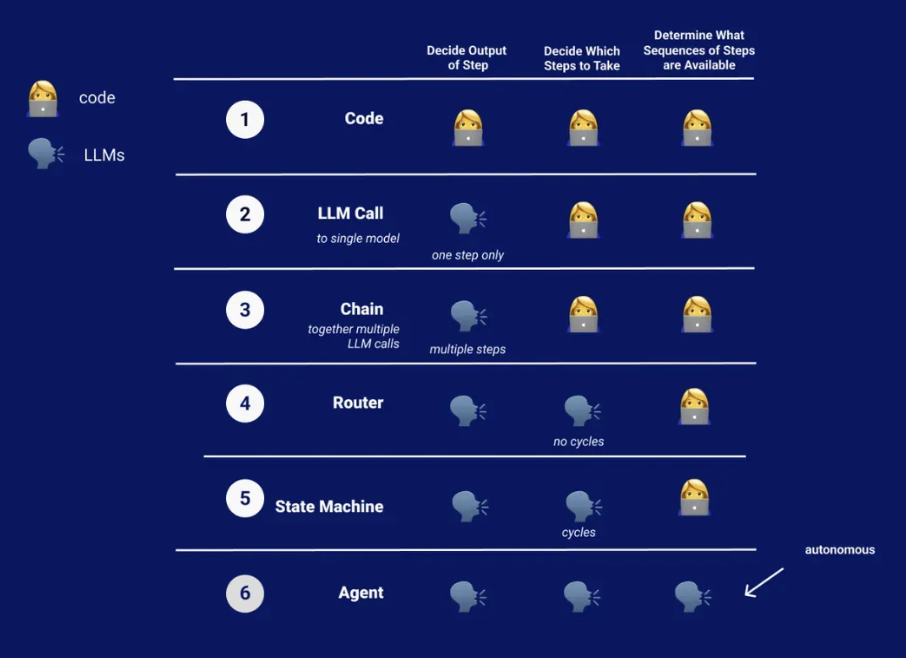

## Setup

In [ ]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [ ]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your OPENAI_API_KEY··········
Please provide your TAVILY_API_KEY··········


## Create Agents

Bu kod, farklı araçları kullanarak iş akışındaki görevleri yerine getiren bir yapay zeka ajanı oluşturur. create_agent fonksiyonu, bir dil modeli (LLM) ve araçlar kullanarak ajanı yapılandırır. Ajan, diğer ajanlarla iş birliği yaparak soruları cevaplamak için görevleri yerine getirir. Ajan, kendisine tanımlanan araçlar ve system_message ile ilerler. Eğer görev tamamlanmışsa, cevabına “FINAL ANSWER” ekleyerek diğer ajanlara işin bittiğini bildirir. Bu yapı, her ajanın eksik kalan işleri tamamlaması üzerine kuruludur.

In [ ]:
from langchain_core.messages import (BaseMessage, HumanMessage, ToolMessage)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages([
            ("system",
             "You are a helpful AI assistant, collaborating with other assistants."
             " Use the provided tools to progress towards answering the question."
             " If you are unable to fully answer, that's OK, another assistant with different tools "
             " will help where you left off. Execute what you can to make progress."
             " If you or any of the other assistants have the final answer or deliverable,"
             " prefix your response with FINAL ANSWER so the team knows to stop."
             " You have access to the following tools: {tool_names}.\n{system_message}"),
            MessagesPlaceholder(variable_name="messages")
        ])

    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    prompt = prompt.partial(system_message=system_message)

    return prompt | llm.bind_tools(tools) # promptu ve araçları dil modeliyle birleştirerek, ajanın araçları etkin şekilde kullanarak görevleri yerine getirebilmesini sağlar.

## Define tools

Bu kod, Langchain kütüphanesi kullanarak bir iş akışında iki araç sağlar: TavilySearchResults, arama sonuçlarını toplar, ve PythonREPL, Python kodlarını çalıştırır. Ayrıca, Python kodlarını çalıştırıp çıktıları döndüren bir fonksiyon tanımlar. Bu araçlar, iş akışında veri arama ve grafik oluşturma gibi görevler için kullanılabilir. Kodlar başarılı bir şekilde çalıştırıldığında, sonuç kullanıcıya gösterilir ve tüm görevler tamamlandığında “FINAL ANSWER” ile işin bittiği belirtilir.

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")

## Create graph

### Define State

Bu kod, iş akışında ajanlar ve araçlar arasındaki mesajları ve hangi ajanın mesajı gönderdiğini takip eden bir veri yapısı (AgentState) tanımlar. Mesajlar iş akışındaki düğümler arasında aktarılır ve her düğümün mesajlarını birleştirerek (operator.add) bir sonraki düğüme iletir. ChatOpenAI kullanarak ajanlar dil modeli ile çalıştırılır.

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_openai import ChatOpenAI

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define Agent Nodes

**agent_node** fonksiyonu, bir ajanın verdiği çıktıyı alır, eğer bu çıktı bir ToolMessage (araç mesajı) değilse, sonuçları AIMessage formatına çevirir ve ajanın adıyla birlikte iş akışındaki genel duruma ekler. Bu fonksiyon, ajanın gönderdiği mesajları ve kimden geldiğini takip eder.

LLM, iş akışındaki ajanların doğal dilde görevleri yerine getirmesine yardımcı olur.

In [ ]:
import functools
from langchain_core.messages import AIMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)

    return {"messages": [result],
            "sender": name}


llm = ChatOpenAI(model="gpt-4o-mini")

**Ajan (Agent) 1:**

research_agent adıyla bir ajan oluşturuldu. Bu ajan, LLM kullanıyor. tavily_tool, bu ajan için araştırma işlemlerinde kullanılacak bir araç (tool). system_message, ajanın görevine yönelik bir sistem mesajı tanımlandı. Bu mesaj, ajanın nasıl davranması gerektiğini belirler. Burada, araştırma ajanına, grafik oluşturucu ajanın kullanacağı verileri sağlaması gerektiği söyleniyor.

**Ajan (Agent) 2:**

chart_agent adıyla ikinci bir ajan oluşturuldu. Bu ajan da, aynı LLM'i kullanıyor. python_repl, bu ajan için bir Python yorumlayıcısı (repl) aracı olarak tanımlandı. Yani bu ajan, Python kodu çalıştırarak grafikler oluşturabilir. system_message, ajanın nasıl davranması gerektiğini açıklayan bir sistem mesajıdır. Burada, ajanın oluşturduğu grafiklerin kullanıcı tarafından görülebileceği belirtildi.

In [ ]:
# Research agent ve node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator ve node
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.")
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

### Define Tool Node

ToolNode, iş akışındaki belirli ajanlar (agent) veya düğümler (node) için tanımlanan araçları kullanarak, ihtiyaç duyulan işlevleri yerine getirir. Örneğin, tavily_tool veri toplamak için çağrılabilirken, python_repl grafik oluşturmak için kullanılabilir. İş akışı, hangi aracın hangi durumda kullanılacağına göre bu araç düğümünden faydalanır.

In [ ]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

Bu kod, iş akışındaki ajanların belirli koşullara göre bir sonraki adıma geçmelerine veya iş akışını sonlandırmalarına karar veren bir yönlendirici (router) işlevi tanımlıyor. Bu işlev, duruma göre hangi yolu izleyeceğini belirlemek için yazılmış.

In [ ]:
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"] # state: İş akışında o anki durumu temsil eder. Genellikle mesajlar, araç çağrıları ve içerik gibi bilgileri içerir.
    last_message = messages[-1] # İş akışındaki son durumda, hangi mesajın son gönderildiğine bakar ve o mesaj üzerinden değerlendirme yapar.

    if last_message.tool_calls: # Eğer son mesajda bir araç çağrısı (tool call) varsa, iş akışındaki ajanlardan biri bir araç (API, harici fonksiyon vs.) çağırmıştır.
        return "call_tool" # "call_tool" döndürülür ve iş akışı “araç çağırma” adımına geçer.

    if "FINAL ANSWER" in last_message.content: # Eğer son mesajda "FINAL ANSWER" ifadesi varsa, bu iş akışında bir ajanın artık işin tamamlandığına karar verdiği anlamına gelir.
        return "__end__" # Bu durumda, "__end__" döndürülür ve iş akışı sonlanır.

    # Bu iki koşulun hiçbiri sağlanmazsa, iş akışı normal şekilde devam eder ve "continue" döndürülür.
    # Böylece ajan bir sonraki adımı gerçekleştirmesi gerektiğini anlar.
    return "continue"

### Define the Graph

Bu iş akışı üç ana ajan (Researcher, chart_generator, call_tool) arasında geçiş yapar ve her bir ajanın duruma göre bir sonraki adımı seçmesine olanak tanır. Ajanlar görevleri tamamladıktan sonra, bir sonraki adıma geçer veya iş akışı sonlanır. “call_tool” düğümü, araç çağırma işlemi için kullanılır ve hangi ajan bu aracı çağırdıysa o düğüme geri döner.

In [ ]:
workflow = StateGraph(AgentState)

# İş akışına bir “Researcher”, bir chart_generator, bir call_tool düğümü ekler.
workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)


# “Researcher” düğümünden çeşitli hedef düğümlere koşullu geçişler belirler.
#  Eğer router fonksiyonu continue döndürürse “chart_generator” düğümüne,
# call_tool dönerse “call_tool” düğümüne, __end__ dönerse iş akışı sonlanır.
workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator",
     "call_tool": "call_tool",
     "__end__": END})


# “chart_generator” düğümünden benzer şekilde geçişleri belirler. Bu düğüm,
# işini tamamladığında ya “Researcher” düğümüne geri döner, ya “call_tool” düğümüne geçer ya da iş akışı sonlanır.
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher",
     "call_tool": "call_tool",
     "__end__": END})


# “call_tool” düğümünde, hangi ajan bu aracı çağırdıysa ona geri dönülür.
# Bu, aracın çağırıldığı orijinal duruma geri dönmek için bir kontrol sağlar.
# Eğer “Researcher” bu aracı çağırdıysa “Researcher” düğümüne, “chart_generator” çağırdıysa “chart_generator” düğümüne döner.
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {"Researcher": "Researcher",
     "chart_generator": "chart_generator"})

# İş akışının başlangıç durumu olarak “Researcher” düğümünü belirler. İş akışı buradan başlar.
workflow.add_edge(START, "Researcher")

graph = workflow.compile()

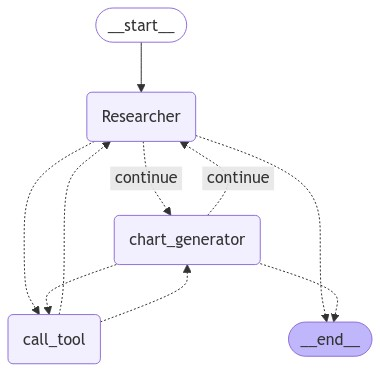

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

## Invoke

Bu kod, bir graf tabanlı iş akışında Türkiye'nin son 5 yıllık GSYİH verilerini alıp çizgi grafiği oluşturma görevini yerine getirir. İş akışı, maksimum 150 adıma kadar çalışacak şekilde sınırlandırılmıştır ve her adımda gerçekleşen olaylar konsola yazdırılır, böylece iş akışının ilerleyişi takip edilebilir.

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XiCpXn1jJ30TBa1bA1L2Rd0F', 'function': {'arguments': '{"query":"Turkey GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 218, 'total_tokens': 243, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_057232b607', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-35a1072b-5349-4fbd-8578-b6f64a688f8c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Turkey GDP over the past 5 years'}, 'id': 'call_XiCpXn1jJ30TBa1bA1L2Rd0F', 'type': 'tool_call'}], usage_metadata={'input_tokens': 218, 'output_tokens': 25, 'total_tokens': 243})], 'sender': 'Researcher'}}
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://tradingeconomics.com/turkey/gd

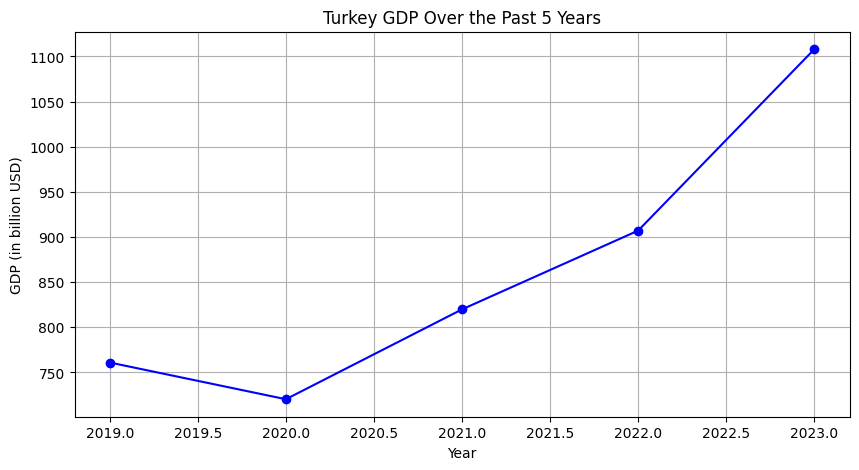

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Data for Turkey's GDP over the past 5 years\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp = [761.01, 720.34, 819.87, 907.12, 1108.02]\n\n# Create a line graph\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp, marker='o', linestyle='-', color='b')\nplt.title('Turkey GDP Over the Past 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billion USD)')\nplt.grid(True)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_OfJLp73jrO7VCvFDqpo7XvKJ')]}}
{'chart_generator': {'messages': [AIMessage(content="FINAL ANSWER\n\nHere is the line graph of Turkey's GDP over the past 5 years:\n\n![Turkey GDP Over the Past 5 Years](attachment://plot.png)\n\n- 2019: \\$761.01 billion\n- 2020: \\$720.34 billion\n- 2021: \\$819.87 billion\n- 2022: \\$907.12 billion\n- 2023: \\$1108.02 billion", additional_kwargs={

In [ ]:
events = graph.stream(
    {"messages": [
        HumanMessage(content="Fetch the Turkey's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish.")]},
    {"recursion_limit": 150}) # Maximum number of steps to take in the graph

for event in events:
    print(event)

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NSK52aN0F7hWWVNfzUMMf3me', 'function': {'arguments': '{"query":"IBM stock prices 2022"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 217, 'total_tokens': 240, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_057232b607', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-59f29733-2453-485e-9e5b-68ec3a380395-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'IBM stock prices 2022'}, 'id': 'call_NSK52aN0F7hWWVNfzUMMf3me', 'type': 'tool_call'}], usage_metadata={'input_tokens': 217, 'output_tokens': 23, 'total_tokens': 240})], 'sender': 'Researcher'}}
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://finance.yahoo.com/quote/IBM/", "content": "211.09. +

[*********************100%***********************]  1 of 1 completed


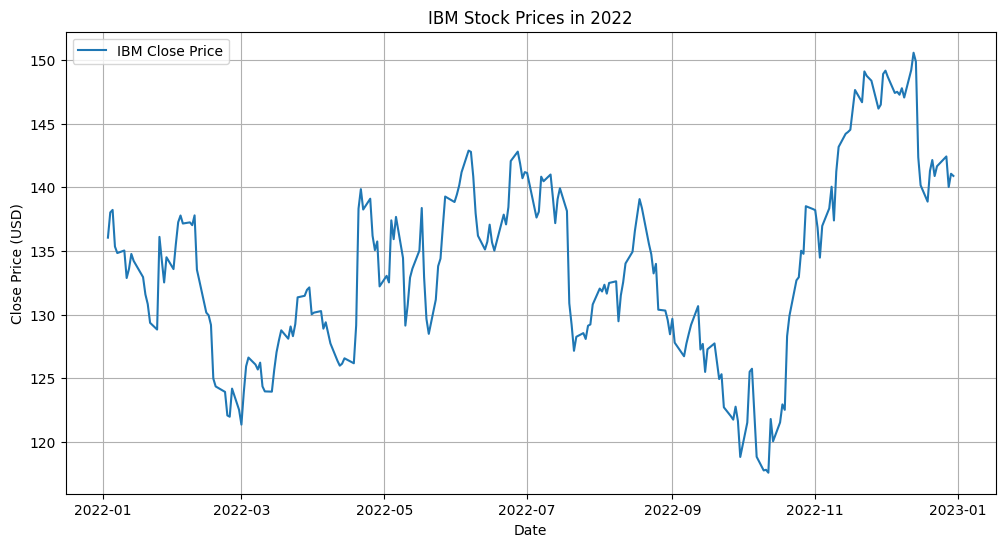

{'call_tool': {'messages': [ToolMessage(content="Successfully executed:\n```python\nimport yfinance as yf\nimport matplotlib.pyplot as plt\n\n# Fetch IBM stock data for 2022\nticker = 'IBM'\ndata = yf.download(ticker, start='2022-01-01', end='2022-12-31')\n\n# Plotting the data\nplt.figure(figsize=(12, 6))\nplt.plot(data.index, data['Close'], label='IBM Close Price')\nplt.title('IBM Stock Prices in 2022')\nplt.xlabel('Date')\nplt.ylabel('Close Price (USD)')\nplt.legend()\nplt.grid(True)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.", name='python_repl', tool_call_id='call_AfzuOgoTQZzXaiTLmCRBSwJm')]}}
{'chart_generator': {'messages': [AIMessage(content="Here is the line graph representing IBM's stock prices for the year 2022:\n\n![IBM Stock Prices in 2022](sandbox:/mnt/data/IBM_Stock_Prices_2022.png)\n\nFINAL ANSWER", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 2225, 'total

In [ ]:
events = graph.stream(
    {"messages": [
        HumanMessage(content="Fetch the IBM's stock prices at 2022,"
                " then draw a line graph of it."
                " Once you code it up, finish.")]},
    {"recursion_limit": 150}) # Maximum number of steps to take in the graph

for event in events:
    print(event)